Ігор Конобас (ТТП-41) <br>
Лабораторна рорбта №1 <br>
Варіант 5

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

%matplotlib inline

In [195]:
data = pd.read_csv('lab1v1.csv')
P, D, S = data['Price'].values, data['Demand'].values, data['Supply'].values

In [196]:
def plot(*args, x='Quantity', y='Price', **kw):
    plt.figure(figsize=(15, 10))
    plt.plot(*args)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(kw['legend'])
    plt.title(kw['title'])
    plt.show()

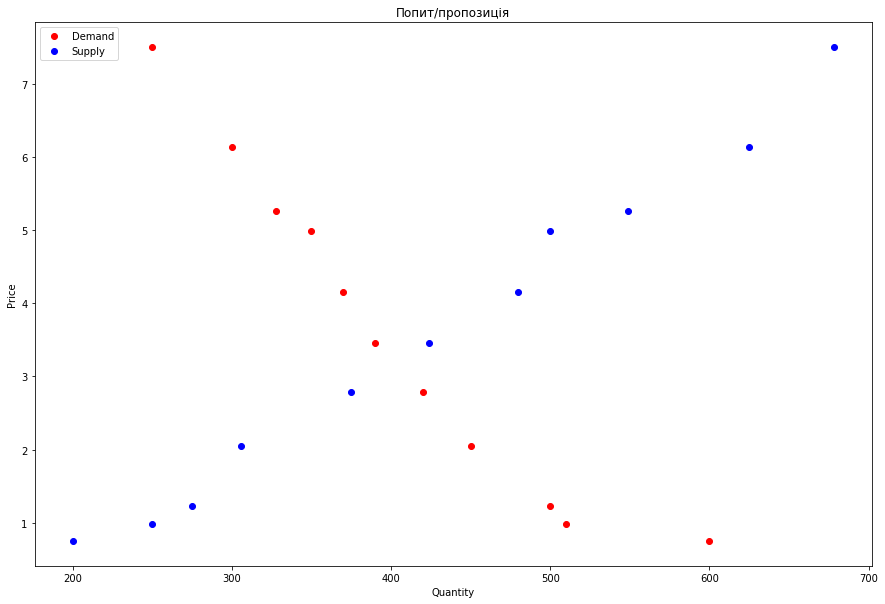

In [197]:
plot(D, P, 'ro', S, P, 'bo', legend=['Demand', 'Supply'], title='Попит/пропозиція')

## Апроксимація

In [198]:
def compare(x, y, fs, label, title):
    plt.figure(figsize=(15, 10))
    scores, cs = [], []
    for i, f in enumerate(fs):
        c, _ = curve_fit(f, x, y)
        fy = f(x, *c)
        plt.plot(fy, x, '-', label=f.__name__)
        scores.append(np.sum(y - fy)**2)
        cs.append(c)
    plt.plot(y, x, 'o', label=label)
    plt.xlabel('Quantity'); plt.ylabel('Price')
    plt.legend(); plt.title(title); plt.show()
    return fs[np.argmin(scores)], cs[np.argmin(scores)]

Апроксимація функції попиту <br>
Лінійна $$Q_d(P) = \frac{a}{bP + c}$$

Експоненційна $$Q_d(P) = \frac{a}{e^{bP} + c}$$

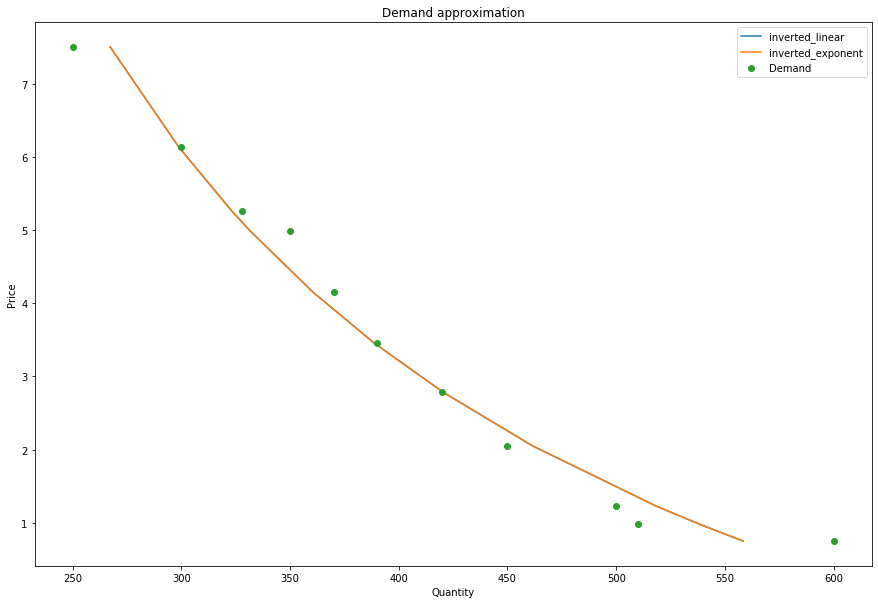

'Функцію попиту краще описує inverted_linear функція'

In [199]:
def inverted_linear(x, a, b, c):   return a / (b*x + c)
def inverted_exponent(x, a, b, c): return a / (np.exp(b*x) + c)

d_f, d_c = compare(P, D, [inverted_linear, inverted_exponent], label='Demand', title='Demand approximation')
'Функцію попиту краще описує {} функція'.format(d_f.__name__)

Апрксимація функції пропозиції <br> 
Експоненційна $$Q_s(P) = e^{aP} + b$$<br> 
Логарифмічна $$Q_s(P) = a\log{P} + b$$

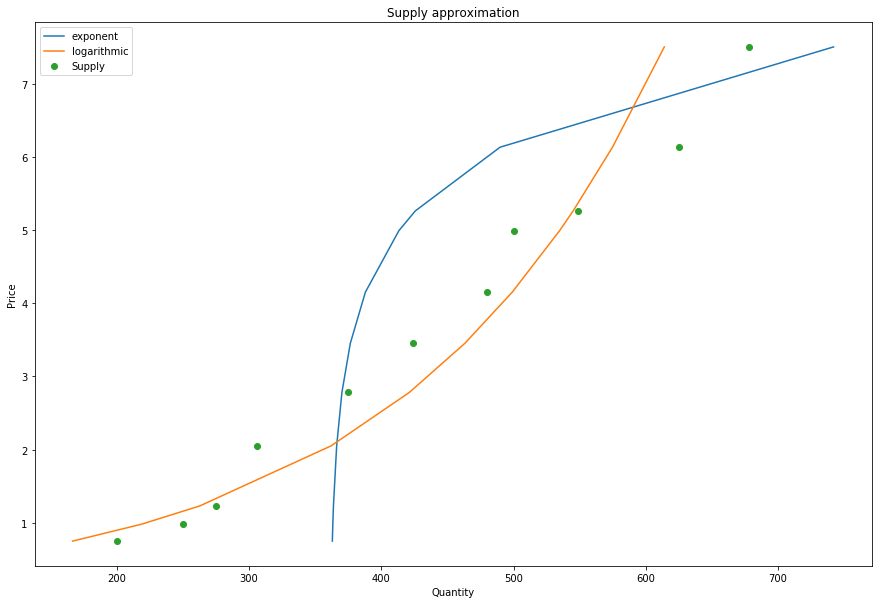

'Функцію пропозиції краще описує logarithmic функція'

In [200]:
def exponent(x, a, b):    return np.exp(a*x) + b
def logarithmic(x, a, b): return a*np.log(x) + b

s_f, s_c = compare(P, S, [exponent, logarithmic], label='Supply', title='Supply approximation')
'Функцію пропозиції краще описує {} функція'.format(s_f.__name__)

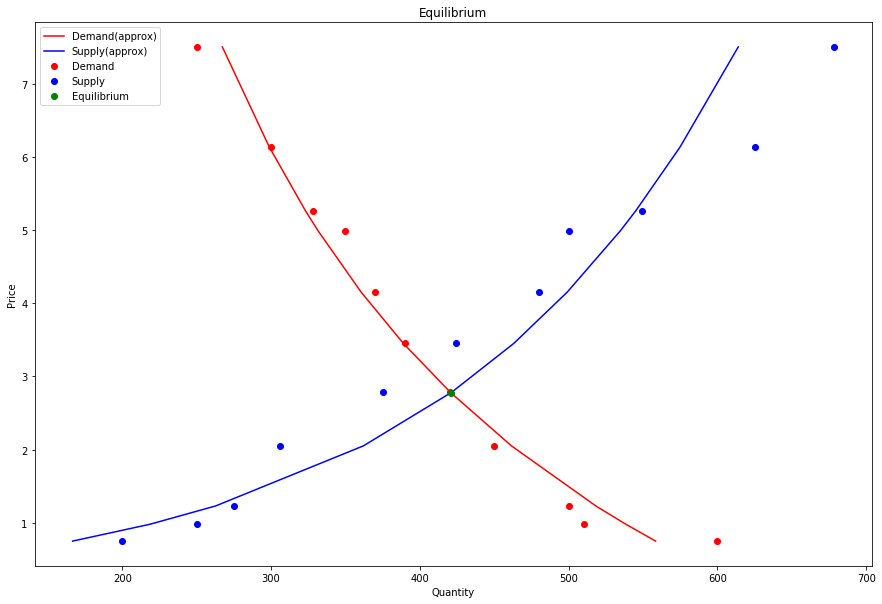

'Точка рівноваги (420.86, 2.78)'

In [201]:
def diff(x): return abs(d_f(x, *d_c) - s_f(x, *s_c))

bounds = (P.min(), P.max())
e_p = minimize(diff, 1, bounds=[bounds]).x[0]
e_q = d_f(e_p, *d_c)
plot(d_f(P, *d_c), P, 'r-', s_f(P, *s_c), P, 'b-', D, P, 'ro', S, P, 'bo', e_q, e_p, 'go',
     legend=['Demand(approx)', 'Supply(approx)', 'Demand', 'Supply', 'Equilibrium'], title='Equilibrium')
'Точка рівноваги ({0:.2f}, {1:.2f})'.format(e_q, e_p)

## Еластичність

def:
$$E = \frac{dQ}{dP} \cdot \frac{P}{Q}$$

Для попиту
$$Q_d = \frac{a}{e^{bP}+c}$$

Для пропозиції
$$Q_s = l\log{P}+m$$


In [202]:
d_c, s_c

(array([1.09875677e+02, 3.17587108e-02, 1.72932509e-01]),
 array([194.26853888, 222.54595522]))

Оскільки $a = 109.9, b = 0.03, c = 0.17, l = 194.2, m = 222.5$, маємо

$$E_d = -\frac{0.03 \cdot Pe^{0.03 P}}{e^{0.03 P}+0.17}$$

$$E_s = \frac{0.17}{0.17\log{P}+222.5}$$

Еластичність в точці рівноваги

In [203]:
def elasticity_d(p): return -d_c[1]*p*np.exp(d_c[1]*p) / (np.exp(d_c[1]*p) - d_c[2])
def elasticity_s(p): return s_c[0] / (s_c[0]*np.log(p) + s_c[1])

print('Еластичність попиту: {0:.2f}'.format(elasticity_d(e_p)))
print('Еластичність пропозиції: {0:.2f}'.format(elasticity_s(e_p)))

Еластичність попиту: -0.10
Еластичність пропозиції: 0.46


Оскільки $|E_d(e_p)| < |E_s(e_p)|$ ==> рівновага **не стабільна**.

## Дугова еластичність

$$E_{arc} = \frac{Q_n - Q_1}{P_n - P_1} \frac{\frac{\sum_{i=1}^n P_i }{n}}{\frac{\sum_{i=1}^n Q_i }{n}} = \frac{Q_n - Q_1}{P_n - P_1} \frac{\sum_{i=1}^n P_i }{\sum_{i=1}^n Q_i }$$

In [204]:
def arc_elasticity(P, Q): return (Q[-1] - Q[0]) / (P[-1] - P[0]) * np.sum(P) / np.sum(Q)

print('Дугова еластичніст попиту: {0:.2f}'.format(arc_elasticity(D, P)))
print('Дугова еластичність пропозиції: {0:.2f}'.format(arc_elasticity(S, P)))

Дугова еластичніст попиту: -2.19
Дугова еластичність пропозиції: 1.68


## Податок в пропозиції

Податок задається рівністю
$$Q_{taxed}(P) = Q(P - tax)$$</br>
Застосуємо це перетворення до функції пропозиції

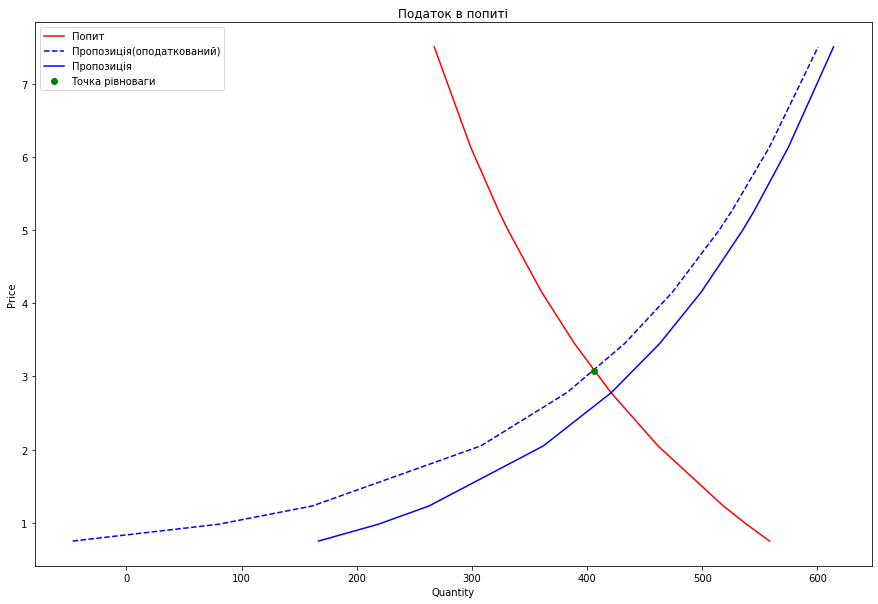

'Точка рівноваги is (406.15, 3.07)'

In [205]:
def taxed_d_f(x): return s_f(x - 0.5, *s_c)
def diff(x): return abs(taxed_d_f(x) - d_f(x, *d_c))

e_p = minimize(diff, 1, bounds=[bounds]).x[0]
e_q = d_f(e_p, *d_c)
plot(d_f(P, *d_c), P, 'r-', taxed_d_f(P), P, 'b--', s_f(P, *s_c), P, 'b-', e_q, e_p, 'go',
    legend=['Попит', 'Пропозиція(оподаткований)', 'Пропозиція', 'Точка рівноваги'], title='Податок в попиті')
'Точка рівноваги is ({0:.2f}, {1:.2f})'.format(e_q, e_p)